<a href="https://colab.research.google.com/github/leenathreddyj/aip/blob/main/Aip-assignment-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

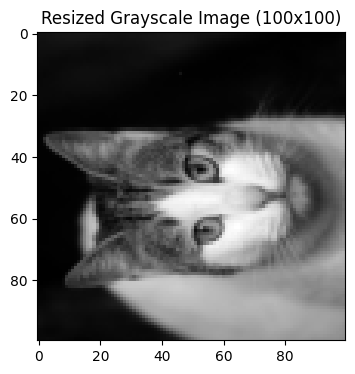

Number of superpixels: 264


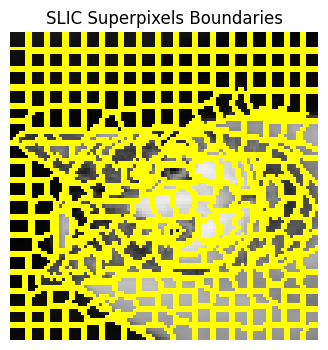

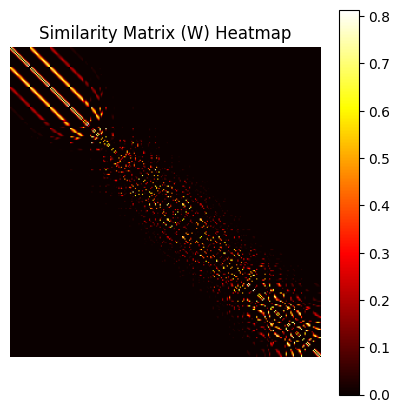

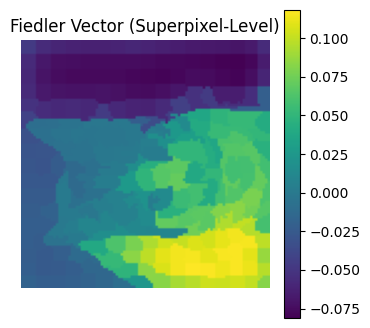

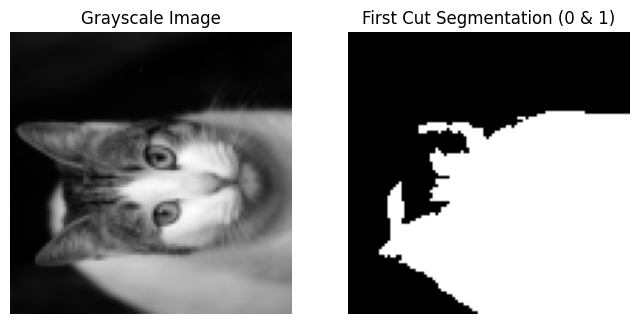

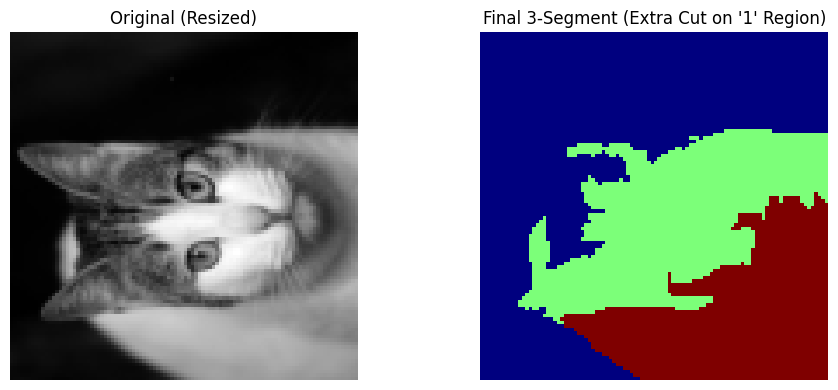

Done! We now have 3 segments: 0 (first cut black), 1 & 2 (subdivided white region).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, transform, segmentation, util
from scipy.sparse import lil_matrix, diags
from scipy.sparse.linalg import eigsh

###############################################################################
# A) Read the Image & Possibly Resize
###############################################################################
image_path = "/content/cat2_1.jpg"  # Update to your file
img = io.imread(image_path)

# Convert to float in [0..1] and grayscale
gray = color.rgb2gray(img)
gray = util.img_as_float(gray)

# Optional resize to speed up processing. For demonstration, do 100x100:
gray_resized = transform.resize(gray, (100, 100), anti_aliasing=True)
# If you prefer full resolution, skip the line above and use 'gray' below.

plt.figure(figsize=(4, 4))
plt.imshow(gray_resized, cmap='gray')
plt.title("Resized Grayscale Image (100x100)")
plt.axis("on")
plt.show()

###############################################################################
# B) Apply SLIC Superpixels
###############################################################################
# We'll choose ~300 superpixels on the 100x100 image
num_segments = 300
slic_labels = segmentation.slic(
    gray_resized,
    n_segments=num_segments,
    compactness=0.1,
    enforce_connectivity=True,
    start_label=0,
    channel_axis=None  # required for 2D grayscale images
)
actual_num_segments = slic_labels.max() + 1
print(f"Number of superpixels: {actual_num_segments}")

# Visualize superpixel boundaries
plt.figure(figsize=(4, 4))
plt.imshow(segmentation.mark_boundaries(gray_resized, slic_labels))
plt.title("SLIC Superpixels Boundaries")
plt.axis("off")
plt.show()

###############################################################################
# C) Compute (x,y) Centroid & Mean Intensity for Each Superpixel
###############################################################################
coords = np.zeros((actual_num_segments, 2), dtype=float)  # [row, col]
intensities = np.zeros(actual_num_segments, dtype=float)
counts = np.zeros(actual_num_segments, dtype=int)

rows, cols = gray_resized.shape
for r in range(rows):
    for c in range(cols):
        seg_id = slic_labels[r, c]
        coords[seg_id, 0] += r
        coords[seg_id, 1] += c
        intensities[seg_id] += gray_resized[r, c]
        counts[seg_id] += 1

# Take the average to get the centroid row,col and mean intensity
for i in range(actual_num_segments):
    coords[i, :] /= counts[i]
    intensities[i] /= counts[i]

# features[i] = [row_i, col_i, intensity_i]
features = np.column_stack((coords, intensities))

###############################################################################
# D) Build Similarity Graph (Sparse Matrix)
###############################################################################
# W(i,j) = exp( -(ΔI)^2 / delta_I^2 ) * exp( - dist(i,j)^2 / delta_d^2 ) if dist< R, else 0
delta_I = 0.1
delta_d = 10.0
R       = 20.0  # maximum distance for centroids to connect

W_sparse = lil_matrix((actual_num_segments, actual_num_segments), dtype=np.float32)

for i in range(actual_num_segments):
    for j in range(i+1, actual_num_segments):
        # Spatial distance
        dist_ij = np.linalg.norm(features[i, :2] - features[j, :2])
        if dist_ij < R:
            # Intensity difference
            diff_I = features[i, 2] - features[j, 2]
            w_ij = np.exp(-(diff_I**2) / (delta_I**2)) * \
                   np.exp(-(dist_ij**2) / (delta_d**2))
            W_sparse[i, j] = w_ij
            W_sparse[j, i] = w_ij

# (Optional) Plot a heatmap of W
plt.figure(figsize=(5, 5))
plt.imshow(W_sparse.toarray(), cmap='hot')
plt.title("Similarity Matrix (W) Heatmap")
plt.colorbar()
plt.axis("off")
plt.show()

###############################################################################
# E) Construct Normalized Laplacian
###############################################################################
row_sums = np.array(W_sparse.sum(axis=1)).ravel()  # shape (num_segments,)
D = diags(row_sums, offsets=0)
L = D - W_sparse  # unnormalized Laplacian

# L_sym = D^{-1/2} * L * D^{-1/2}
inv_sqrt = 1.0 / np.sqrt(row_sums + 1e-12)
D_inv_sqrt = diags(inv_sqrt)
L_sym = D_inv_sqrt @ L @ D_inv_sqrt

###############################################################################
# F) Solve for 2 Smallest Eigenvalues -> Fiedler Vector => 1st Cut
###############################################################################
eigvals, eigvecs = eigsh(L_sym, k=2, which='SM')
idx_sort = np.argsort(eigvals)
fiedler_vec = eigvecs[:, idx_sort[1]]

# Visualize Fiedler vector across superpixels
fiedler_map = np.zeros_like(slic_labels, dtype=float)
for i in range(actual_num_segments):
    fiedler_map[slic_labels == i] = fiedler_vec[i]

plt.figure(figsize=(4, 4))
plt.imshow(fiedler_map, cmap='viridis')
plt.title("Fiedler Vector (Superpixel-Level)")
plt.colorbar()
plt.axis("off")
plt.show()

###############################################################################
# G) Simple Threshold -> Binary Segmentation (Labels 0,1)
###############################################################################
threshold = np.median(fiedler_vec)
binary_partition = (fiedler_vec > threshold)  # True => "white region", False => "black region"

# Map superpixel-based labels [0 or 1] to the image
seg_map_firstcut = np.zeros_like(slic_labels, dtype=int)
for i in range(actual_num_segments):
    seg_map_firstcut[slic_labels == i] = int(binary_partition[i])

# Show the 2-segment (0,1) result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray_resized, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(seg_map_firstcut, cmap='gray')
plt.title("First Cut Segmentation (0 & 1)")
plt.axis("off")
plt.show()

###############################################################################
# H) SECOND CUT: Only on superpixels labeled 1 ("white region") => yields 3 segments total
###############################################################################
from scipy.sparse import csr_matrix

W_csr = csr_matrix(W_sparse)

# Indices of superpixels that were labeled 1 in the first cut
white_indices = np.where(binary_partition)[0]  # these correspond to "white region" superpixels

if len(white_indices) < 2:
    # not enough superpixels to subdivide further
    print("White region has <2 superpixels; can't do second cut.")
    final_segmap = seg_map_firstcut  # no change
else:
    # Build subgraph for the white region
    # Keep the adjacency among white_indices only
    W_sub = W_csr[white_indices, :][:, white_indices]

    # Build degree, Laplacian, etc., for the subgraph
    sub_row_sums = np.array(W_sub.sum(axis=1)).ravel()
    D_sub = diags(sub_row_sums)
    L_sub = D_sub - W_sub
    inv_sqrt_sub = 1.0 / np.sqrt(sub_row_sums + 1e-12)
    D_inv_sqrt_sub = diags(inv_sqrt_sub)
    L_sym_sub = D_inv_sqrt_sub @ L_sub @ D_inv_sqrt_sub

    # Solve for 2 smallest eigenvalues in the subgraph
    vals_sub, vecs_sub = eigsh(L_sym_sub, k=2, which='SM')
    idx_sub_sort = np.argsort(vals_sub)
    fiedler_vec_sub = vecs_sub[:, idx_sub_sort[1]]

    # Simple threshold in the sub-Fiedler vector
    t_sub = np.median(fiedler_vec_sub)
    second_cut_partition = (fiedler_vec_sub > t_sub)  # True => subregion #2, False => subregion #1

    # We'll define final labels in the sub-region as 1 or 2
    # while the black region from the first cut remains label 0.

    final_labels = np.zeros_like(binary_partition, dtype=int)  # shape = [actual_num_segments]
    # black region from first cut => label 0
    final_labels[~binary_partition] = 0
    # white region is subdivided => two sub-regions
    # sub region #1 => label 1
    # sub region #2 => label 2
    white_indices_sub1 = white_indices[~second_cut_partition]
    white_indices_sub2 = white_indices[second_cut_partition]
    final_labels[white_indices_sub1] = 1
    final_labels[white_indices_sub2] = 2

    # Map to pixel space
    final_segmap = np.zeros_like(slic_labels, dtype=int)
    for sp_idx in range(actual_num_segments):
        final_segmap[slic_labels == sp_idx] = final_labels[sp_idx]

###############################################################################
# I) Display the Final 3-Segment Result (labels: 0,1,2)
###############################################################################
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(gray_resized, cmap='gray')
axs[0].set_title("Original (Resized)")
axs[0].axis("off")

axs[1].imshow(final_segmap, cmap='jet')
axs[1].set_title("Final 3-Segment (Extra Cut on '1' Region)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

print("Done! We now have 3 segments: 0 (first cut black), 1 & 2 (subdivided white region).")
